Deconvolution Training and Reconstructions with MoDL
====================================================

This example demonstrates the training and application of a
model-based deep learning (MoDL) architecture described in
<cite data-cite="aggarwal-2019-modl"/> for a deconvolution (deblurring) problem.

The source images are foam phantoms generated with xdesign.

A class
[scico.flax.MoDLNet](../_autosummary/scico.flax.rst#scico.flax.MoDLNet)
implements the MoDL architecture, which solves the optimization
problem

$$\mathrm{argmin}_{\mathbf{x}} \; \| A \mathbf{x} - \mathbf{y} \|_2^2
+ \lambda \, \| \mathbf{x} - \mathrm{D}_w(\mathbf{x})\|_2^2 \;,$$

where $A$ is a circular convolution, $\mathbf{y}$ is a set of blurred
images, $\mathrm{D}_w$ is the regularization (a denoiser), and
$\mathbf{x}$ is the set of deblurred images. The MoDL abstracts the
iterative solution by an unrolled network where each iteration
corresponds to a different stage in the MoDL network and updates the
prediction by solving

$$\mathbf{x}^{k+1} = (A^T A + \lambda \, I)^{-1} (A^T \mathbf{y} +
\lambda \, \mathbf{z}^k) \;,$$

via conjugate gradient. In the expression, $k$ is the index of the stage
(iteration), $\mathbf{z}^k = \mathrm{ResNet}(\mathbf{x}^{k})$ is the
regularization (a denoiser implemented as a residual convolutional neural
network), $\mathbf{x}^k$ is the output of the previous stage,
$\lambda > 0$ is a learned regularization parameter, and $I$ is the
identity operator. The output of the final stage is the set of deblurred
images.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install git+https://github.com/lanl/scico
!pip install ray

# isort: off
import os
from functools import partial
from time import time

import numpy as np

import logging
import ray

ray.init(logging_level=logging.ERROR)  # need to call init before jax import: ray-project/ray#44087

# Set an arbitrary processor count (only applies if GPU is not available).
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import jax

try:
    from jax.extend.backend import get_backend  # introduced in jax 0.4.33
except ImportError:
    from jax.lib.xla_bridge import get_backend

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scico import flax as sflax
from scico import metric, plot
from scico.flax.examples import load_blur_data
from scico.flax.train.traversals import clip_positive, construct_traversal
from scico.linop import CircularConvolve
plot.config_notebook_plotting()


platform = get_backend().platform
print("Platform: ", platform)

Platform:  gpu


Define blur operator.

In [2]:
output_size = 256  # image size

n = 3  # convolution kernel size
σ = 20.0 / 255  # noise level
psf = np.ones((n, n)) / (n * n)  # blur kernel

ishape = (output_size, output_size)
opBlur = CircularConvolve(h=psf, input_shape=ishape)
opBlur_vmap = jax.vmap(opBlur)  # for batch processing in data generation

Read data from cache or generate if not available.

In [3]:
train_nimg = 416  # number of training images
test_nimg = 64  # number of testing images
nimg = train_nimg + test_nimg

train_ds, test_ds = load_blur_data(
    train_nimg,
    test_nimg,
    output_size,
    psf,
    σ,
    verbose=True,
)

Data read from path: ~/.cache/scico/examples/data
Set --training-- size: 416
Set --testing -- size: 64
Data range -- images --  Min:  0.00  Max:  1.00
Data range -- labels --  Min:  0.00  Max:  1.00


Define configuration dictionary for model and training loop.

Parameters have been selected for demonstration purposes and relatively
short training. The model depth is akin to the number of unrolled
iterations in the MoDL model. The block depth controls the number of
layers at each unrolled iteration. The number of filters is uniform
throughout the iterations. The iterations used for the conjugate gradient
(CG) solver can also be specified. Better performance may be obtained by
increasing depth, block depth, number of filters, CG iterations, or
training epochs, but may require longer training times.

In [4]:
# model configuration
model_conf = {
    "depth": 2,
    "num_filters": 64,
    "block_depth": 4,
    "cg_iter": 4,
}
# training configuration
train_conf: sflax.ConfigDict = {
    "seed": 0,
    "opt_type": "SGD",
    "momentum": 0.9,
    "batch_size": 16,
    "num_epochs": 25,
    "base_learning_rate": 1e-2,
    "warmup_epochs": 0,
    "log_every_steps": 100,
    "log": True,
    "checkpointing": True,
}

Construct functionality for ensuring that the learned regularization
parameter is always positive.

In [5]:
lmbdatrav = construct_traversal("lmbda")  # select lmbda parameters in model
lmbdapos = partial(
    clip_positive,  # apply this function
    traversal=lmbdatrav,  # to lmbda parameters in model
    minval=5e-4,
)

Print configuration of distributed run.

In [6]:
print(f"\nJAX process: {jax.process_index()}{' / '}{jax.process_count()}")
print(f"JAX local devices: {jax.local_devices()}\n")


JAX process: 0 / 1
JAX local devices: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3), CudaDevice(id=4), CudaDevice(id=5), CudaDevice(id=6), CudaDevice(id=7)]



Check for iterated trained model. If not found, construct MoDLNet model,
using only one iteration (depth) in model and few CG iterations for
faster intialization. Run first stage (initialization) training loop
followed by a second stage (depth iterations) training loop.

In [7]:
channels = train_ds["image"].shape[-1]
workdir2 = os.path.join(
    os.path.expanduser("~"), ".cache", "scico", "examples", "modl_dcnv_out", "iterated"
)

stats_object_ini = None
stats_object = None

checkpoint_files = []
for dirpath, dirnames, filenames in os.walk(workdir2):
    checkpoint_files = [fn for fn in filenames]

if len(checkpoint_files) > 0:
    model = sflax.MoDLNet(
        operator=opBlur,
        depth=model_conf["depth"],
        channels=channels,
        num_filters=model_conf["num_filters"],
        block_depth=model_conf["block_depth"],
        cg_iter=model_conf["cg_iter"],
    )

    train_conf["workdir"] = workdir2
    train_conf["post_lst"] = [lmbdapos]
    # Construct training object
    trainer = sflax.BasicFlaxTrainer(
        train_conf,
        model,
        train_ds,
        test_ds,
    )
    start_time = time()
    modvar, stats_object = trainer.train()
    time_train = time() - start_time
    time_init = 0.0
    epochs_init = 0
else:
    # One iteration (depth) in model and few CG iterations
    model = sflax.MoDLNet(
        operator=opBlur,
        depth=1,
        channels=channels,
        num_filters=model_conf["num_filters"],
        block_depth=model_conf["block_depth"],
        cg_iter=model_conf["cg_iter"],
    )
    # First stage: initialization training loop.
    workdir1 = os.path.join(os.path.expanduser("~"), ".cache", "scico", "examples", "modl_dcnv_out")
    train_conf["workdir"] = workdir1
    train_conf["post_lst"] = [lmbdapos]
    # Construct training object
    trainer = sflax.BasicFlaxTrainer(
        train_conf,
        model,
        train_ds,
        test_ds,
    )

    start_time = time()
    modvar, stats_object_ini = trainer.train()
    time_init = time() - start_time
    epochs_init = train_conf["num_epochs"]

    print(
        f"{'MoDLNet init':18s}{'epochs:':2s}{train_conf['num_epochs']:>5d}{'':3s}"
        f"{'time[s]:':21s}{time_init:>7.2f}"
    )

    # Second stage: depth iterations training loop.
    model.depth = model_conf["depth"]
    train_conf["workdir"] = workdir2
    # Construct training object, include current model parameters
    trainer = sflax.BasicFlaxTrainer(
        train_conf,
        model,
        train_ds,
        test_ds,
        variables0=modvar,
    )

    start_time = time()
    modvar, stats_object = trainer.train()
    time_train = time() - start_time

channels: 1   training signals: 416   testing signals: 64   signal size: 256



Network Structure:
+------------------------------------------+----------------+--------+-----------+--------+
| Name                                     | Shape          | Size   | Mean      | Std    |
+------------------------------------------+----------------+--------+-----------+--------+
| ResNet_0/BatchNorm_0/bias                | (1,)           | 1      | 0.0       | 0.0    |
| ResNet_0/BatchNorm_0/scale               | (1,)           | 1      | 1.0       | 0.0    |
| ResNet_0/ConvBNBlock_0/BatchNorm_0/bias  | (64,)          | 64     | 0.0       | 0.0    |
| ResNet_0/ConvBNBlock_0/BatchNorm_0/scale | (64,)          | 64     | 1.0       | 0.0    |
| ResNet_0/ConvBNBlock_0/Conv_0/kernel     | (3, 3, 1, 64)  | 576    | -0.00161  | 0.0603 |
| ResNet_0/ConvBNBlock_1/BatchNorm_0/bias  | (64,)          | 64     | 0.0       | 0.0    |
| ResNet_0/ConvBNBlock_1/BatchNorm_0/scale | (64,)          | 64     | 1.0       | 0.0    |
| ResNet_0/ConvBNBlock_1/Conv_0/kernel     | (3, 3, 64, 64) |

Initial compilation, which might take some time ...


Initial compilation completed.



Epoch  Time      Train_LR  Train_Loss  Train_SNR  Eval_Loss  Eval_SNR
---------------------------------------------------------------------
    3  7.44e+00  0.010000    0.018961       9.28   0.005802     12.26


    7  1.04e+01  0.010000    0.005925      12.16   0.005808     12.26


   11  1.23e+01  0.010000    0.005800      12.25   0.005773     12.28


   15  1.40e+01  0.010000    0.005642      12.37   0.005745     12.30


   19  1.56e+01  0.010000    0.005442      12.53   0.005670     12.36


   23  1.74e+01  0.010000    0.005139      12.78   0.005423     12.55


MoDLNet init      epochs:   25   time[s]:               19.70
channels: 1   training signals: 416   testing signals: 64   signal size: 256

Network Structure:
+------------------------------------------+----------------+--------+-----------+----------+
| Name                                     | Shape          | Size   | Mean      | Std      |
+------------------------------------------+----------------+--------+-----------+----------+
| ResNet_0/BatchNorm_0/bias                | (1,)           | 1      | -0.0253   | 0.0      |
| ResNet_0/BatchNorm_0/scale               | (1,)           | 1      | 0.683     | 0.0      |
| ResNet_0/ConvBNBlock_0/BatchNorm_0/bias  | (64,)          | 64     | -2.06e-05 | 0.000882 |
| ResNet_0/ConvBNBlock_0/BatchNorm_0/scale | (64,)          | 64     | 1.0       | 0.00101  |
| ResNet_0/ConvBNBlock_0/Conv_0/kernel     | (3, 3, 1, 64)  | 576    | -4.42e-05 | 0.0607   |
| ResNet_0/ConvBNBlock_1/BatchNorm_0/bias  | (64,)          | 64     | 7.07e-05  | 0.0006

Initial compilation completed.



Epoch  Time      Train_LR  Train_Loss  Train_SNR  Eval_Loss  Eval_SNR
---------------------------------------------------------------------
    3  6.71e+00  0.010000    0.004709      13.17   0.004244     13.62


    7  1.13e+01  0.010000    0.004000      13.87   0.003801     14.10


   11  1.42e+01  0.010000    0.003598      14.33   0.003571     14.37


   15  1.69e+01  0.010000    0.003270      14.74   0.003439     14.53


   19  1.96e+01  0.010000    0.003004      15.11   0.003171     14.88


   23  2.24e+01  0.010000    0.002826      15.38   0.002946     15.20


Evaluate on testing data.

In [8]:
del train_ds["image"]
del train_ds["label"]

fmap = sflax.FlaxMap(model, modvar)
del model, modvar

maxn = test_nimg // 4
start_time = time()
output = fmap(test_ds["image"][:maxn])
time_eval = time() - start_time
output = np.clip(output, a_min=0, a_max=1.0)

Evaluate trained model in terms of reconstruction time
and data fidelity.

In [9]:
total_epochs = epochs_init + train_conf["num_epochs"]
total_time_train = time_init + time_train
snr_eval = metric.snr(test_ds["label"][:maxn], output)
psnr_eval = metric.psnr(test_ds["label"][:maxn], output)
print(
    f"{'MoDLNet training':18s}{'epochs:':2s}{total_epochs:>5d}{'':21s}"
    f"{'time[s]:':10s}{total_time_train:>7.2f}"
)
print(
    f"{'MoDLNet testing':18s}{'SNR:':5s}{snr_eval:>5.2f}{' dB'}"
    f"{'':3s}{'PSNR:':6s}{psnr_eval:>5.2f}{' dB'}{'':3s}{'time[s]:':10s}{time_eval:>7.2f}"
)

MoDLNet training  epochs:   50                     time[s]:    43.65
MoDLNet testing   SNR: 16.20 dB   PSNR: 23.28 dB   time[s]:     2.77


Plot comparison.

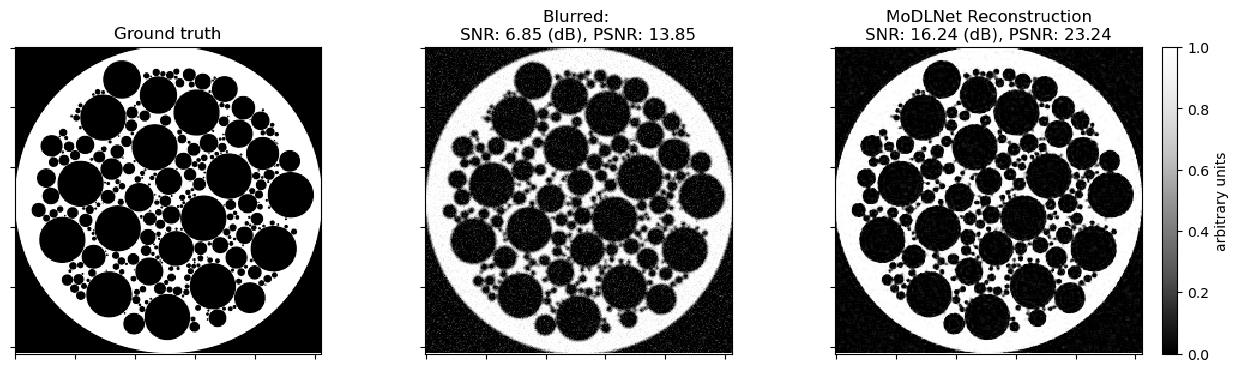

In [10]:
np.random.seed(123)
indx = np.random.randint(0, high=maxn)

fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(test_ds["label"][indx, ..., 0], title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    test_ds["image"][indx, ..., 0],
    title="Blurred: \nSNR: %.2f (dB), PSNR: %.2f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], test_ds["image"][indx, ..., 0]),
        metric.psnr(test_ds["label"][indx, ..., 0], test_ds["image"][indx, ..., 0]),
    ),
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    output[indx, ..., 0],
    title="MoDLNet Reconstruction\nSNR: %.2f (dB), PSNR: %.2f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
        metric.psnr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
    ),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics. Statistics are generated only if a training
cycle was done (i.e. if not reading final epoch results from checkpoint).

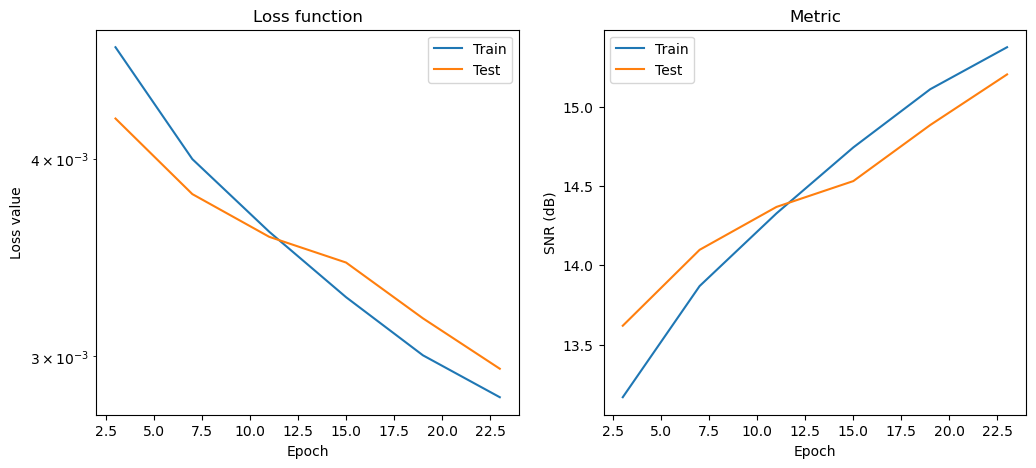

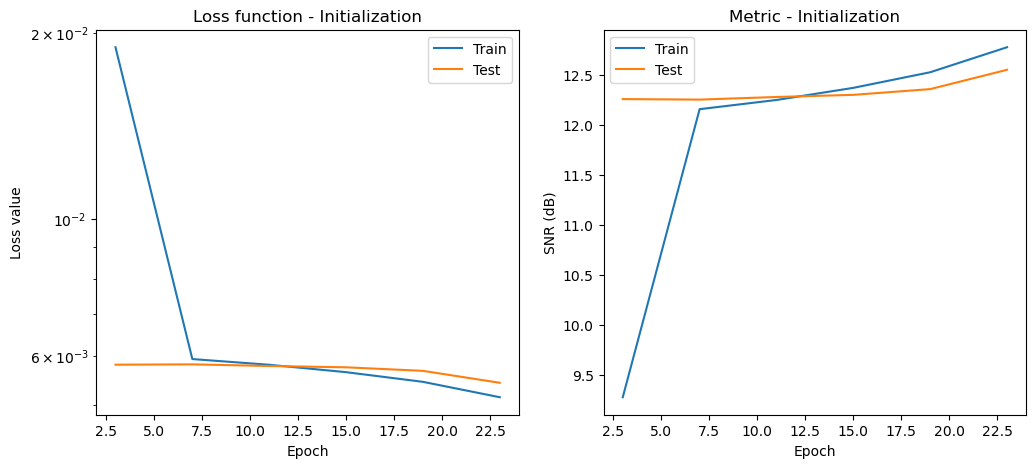

In [11]:
if stats_object is not None and len(stats_object.iterations) > 0:
    hist = stats_object.history(transpose=True)
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot.plot(
        np.vstack((hist.Train_Loss, hist.Eval_Loss)).T,
        x=hist.Epoch,
        ptyp="semilogy",
        title="Loss function",
        xlbl="Epoch",
        ylbl="Loss value",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[0],
    )
    plot.plot(
        np.vstack((hist.Train_SNR, hist.Eval_SNR)).T,
        x=hist.Epoch,
        title="Metric",
        xlbl="Epoch",
        ylbl="SNR (dB)",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[1],
    )
    fig.show()

# Stats for initialization loop
if stats_object_ini is not None and len(stats_object_ini.iterations) > 0:
    hist = stats_object_ini.history(transpose=True)
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot.plot(
        np.vstack((hist.Train_Loss, hist.Eval_Loss)).T,
        x=hist.Epoch,
        ptyp="semilogy",
        title="Loss function - Initialization",
        xlbl="Epoch",
        ylbl="Loss value",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[0],
    )
    plot.plot(
        np.vstack((hist.Train_SNR, hist.Eval_SNR)).T,
        x=hist.Epoch,
        title="Metric - Initialization",
        xlbl="Epoch",
        ylbl="SNR (dB)",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[1],
    )
    fig.show()